# This is the in situ and SSS collocation code. 


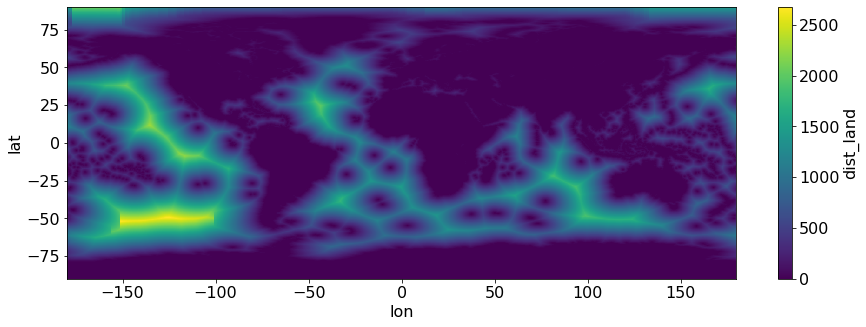

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import scipy
from glob import glob
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition
from pyresample.kd_tree import resample_nearest
import sys
sys.path.append('../saildrone/subroutines/')
from read_routines import read_one_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages


ds = xr.open_dataset('f:/data/sat_data/distance_to_land_25km.nc').rename({'i2':'lon','j2':'lat'})
ds['lat'],ds['lon']=np.arange(-89.875,89.876,.25),np.arange(-179.875,179.876,.25)#np.arange(.125,359.876,.25)
#ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
#ds = ds.sortby(ds.lon)
ds_land=ds
plt.rcParams['figure.figsize'] = (15,5)
ds_land.dist_land.plot()

# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.



In [2]:
dir_data = 'C:/Users/gentemann/Google Drive/public/ALL_saildrone_data/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/ALL_saildrone_data/*west*.nc' 

#get list of all filenames in directory
files = glob(dir_data_pattern)
print('number of file:',len(files))
for ifile,file in enumerate(files):
    print(ifile,file)

number of file: 13
0 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1024.nc
1 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1025.nc
2 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1026.nc
3 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1027.nc
4 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2018_sd1028.nc
5 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1038.nc
6 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1039.nc
7 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1040.nc
8 C:/Users/gentemann/Google Drive/public/ALL_saildrone_data\saildrone_west_coast_survey_2019_sd1043.nc
9 C:/Users/gentemann/Google Drive/public/ALL_saildrone

In [3]:
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
iname=0
ds_usv=[]
for file in files:
    ds = read_one_usv(file)
    ds_usv.append(ds[0])
ds_usv=xr.concat(ds_usv,dim='trajectory')
#ds_usv = xr.open_mfdataset(files,concat_dim='trajectory')
#ds_usv.close()
#ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
#ds_usv = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) #get rid of last part and first part where USV being towed
#ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
#ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
#ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
#ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
#ds_usv

In [4]:
ds_usv

<xarray.Dataset>
Dimensions:                       (time: 350468, trajectory: 13)
Coordinates:
  * time                          (time) datetime64[ns] 2018-06-27 ... 2019-0...
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables:
    lat                           (trajectory, time) float64 nan nan ... nan nan
    lon                           (trajectory, time) float64 nan nan ... nan nan
    SOG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    COG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    HDG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    PITCH_MEAN                    (trajectory, time) float64 nan nan ... nan nan
    BARO_PRES_MEAN                (trajectory, time) float64 nan nan ... nan nan
    TEMP_AIR_MEAN                 (trajectory, time) float64 nan nan ... nan nan
    RH_MEAN                       (trajectory, time) float64 nan nan ... nan nan
    PAR_AIR_MEAN                  (trajectory, time) float64 nan nan ... nan nan
    UWND_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    VWND_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    WWND_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    GUST_WND_MEAN                 (trajectory, time) float64 nan nan ... nan nan
    TEMP_CTD_MEAN                 (trajectory, time) float64 nan nan ... nan nan
    TEMP_CTD_STDDEV               (trajectory, time) float64 nan nan ... nan nan
    SAL_CTD_MEAN                  (trajectory, time) float64 nan nan ... nan nan
    CHLOR_MEAN                    (trajectory, time) float64 nan nan ... nan nan
    ROLL_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    TEMP_RBR_MEAN                 (trajectory, time) float64 nan nan ... nan nan
    SAL_RBR_MEAN                  (trajectory, time) float64 nan nan ... nan nan
    TEMP_O2_RBR_MEAN              (trajectory, time) float64 nan nan ... nan nan
    CDOM_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    CHLOR_WETLABS_MEAN            (trajectory, time) float64 nan nan ... nan nan
    WIND_MEASUREMENT_HEIGHT_MEAN  (trajectory, time) float64 nan nan ... nan nan
Attributes:
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    creator_url:               http://saildrone.com/
    data_mode:                 realtime
    date_created:              2018-10-06T00:30:01.915026Z
    description:               Saildrone NetCDF Format
    drone_id:                  1028
    Easternmost_Easting:       -120.5020928
    featureType:               Trajectory
    geospatial_lat_max:        40.0555744
    geospatial_lat_min:        33.8146944
    geospatial_lat_units:      degrees_north
    geospatial_lon_max:        -120.5020928
    geospatial_lon_min:        -124.915008
    geospatial_lon_units:      degrees_east
    history:                   FERRET V7.504  21-Jul-19\n2020-05-07T16:30:14Z...
    id:                        8708
    infoUrl:                   http://saildrone.com/
    institution:               Saildrone
    interval:                  60.0
    keywords:                  active, air, air_pressure, air_temperature, an...
    keywords_vocabulary:       GCMD Science Keywords
    license:                   The data may be used and redistributed for fre...
    naming_authority:          com.saildrone
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    netcdf_version:            4.4.1.1
    Northernmost_Northing:     40.0555744
    platform:                  Saildrone
    project:                   west_coast_survey_2018
    sourceUrl:                 (local files)
    Southernmost_Northing:     33

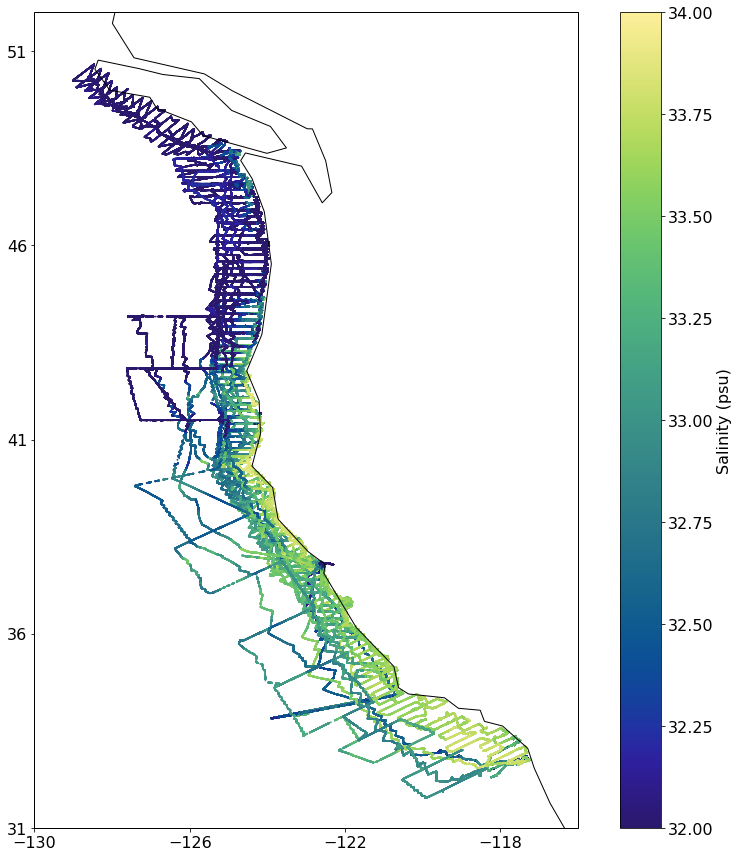

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.SAL_CTD_MEAN, edgecolor='none', cmap=cmocean.cm.haline,vmin=32,vmax=34)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [103]:
np.datetime64('2019-06-19')

numpy.datetime64('2019-06-19')

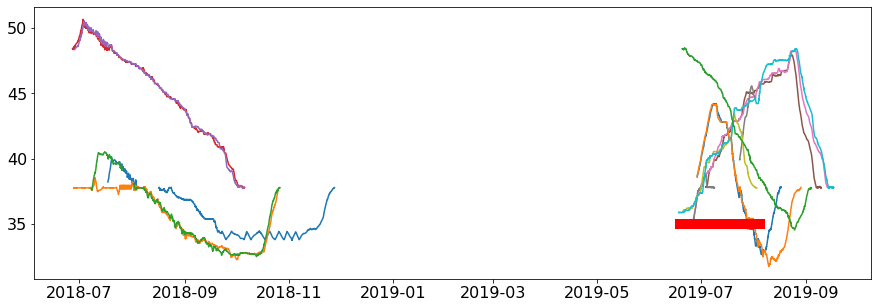

In [106]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.plot(ds.time,ds.lat)
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-08-05')],[35,35],'r',linewidth=10) #DATA OUTAGE
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises_timeseries.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [23]:
dir_data = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_patternJ = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*JPL*.nc' 
dir_data_patternR = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*RSS*.nc' 

#get list of all filenames in directory
cfilesJ = glob(dir_data_patternJ)
cfilesR = glob(dir_data_patternR)
print('number of file:',len(cfilesR))
for ifile,file in enumerate(cfilesJ):
    print(ifile,file)

number of file: 13
0 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1024jplv04.3_orbitalnorep.nc
1 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1025jplv04.3_orbitalnorep.nc
2 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1026jplv04.3_orbitalnorep.nc
3 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1027jplv04.3_orbitalnorep.nc
4 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1028jplv04.3_orbitalnorep.nc
5 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1038jplv04.3_orbitalnorep.nc
6 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1039jplv04.3_orbitalnorep.nc
7 F:/data/cruise_data/saildrone/sss/sss_col

In [109]:
ds2=[]
for i in range(len(cfilesJ)):
    ds = xr.open_dataset(cfilesJ[i])
    ds2.append(ds)
ds_colJ = xr.concat(ds2,dim='trajectory')
ds2=[]
for i in range(len(cfilesR)):
    ds = xr.open_dataset(cfilesR[i])
    ds2.append(ds)
ds_colR = xr.concat(ds2,dim='trajectory')

ds=ds_land.interp(lat=ds_colJ.lat,lon=ds_colJ.lon).drop({'lat','lon'})
ds_colJ['dist_land']=ds.dist_land
ds=ds_land.interp(lat=ds_colR.lat,lon=ds_colR.lon).drop({'lat','lon'})
ds_colR['dist_land']=ds.dist_land

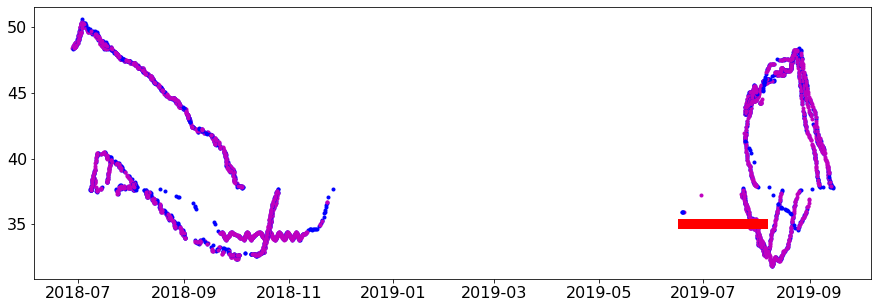

In [122]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_colJ.isel(trajectory=i)
    plt.plot(ds.time,ds.lat,'.',color='b',linewidth=3)
    ds=ds_colR.isel(trajectory=i)
    plt.plot(ds.time,ds.lat,'.',color='m')
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-08-05')],[35,35],'r',linewidth=10) #DATA OUTAGE
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_coll_cruises_timeseriesJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

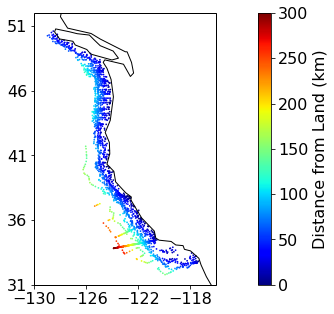

In [189]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
#    ds = ds.where(ds.dist_land>30)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

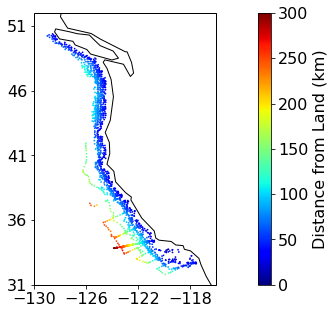

In [124]:
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceRSS.png'
plt.savefig(fig_fname, transparent=False, format='png')

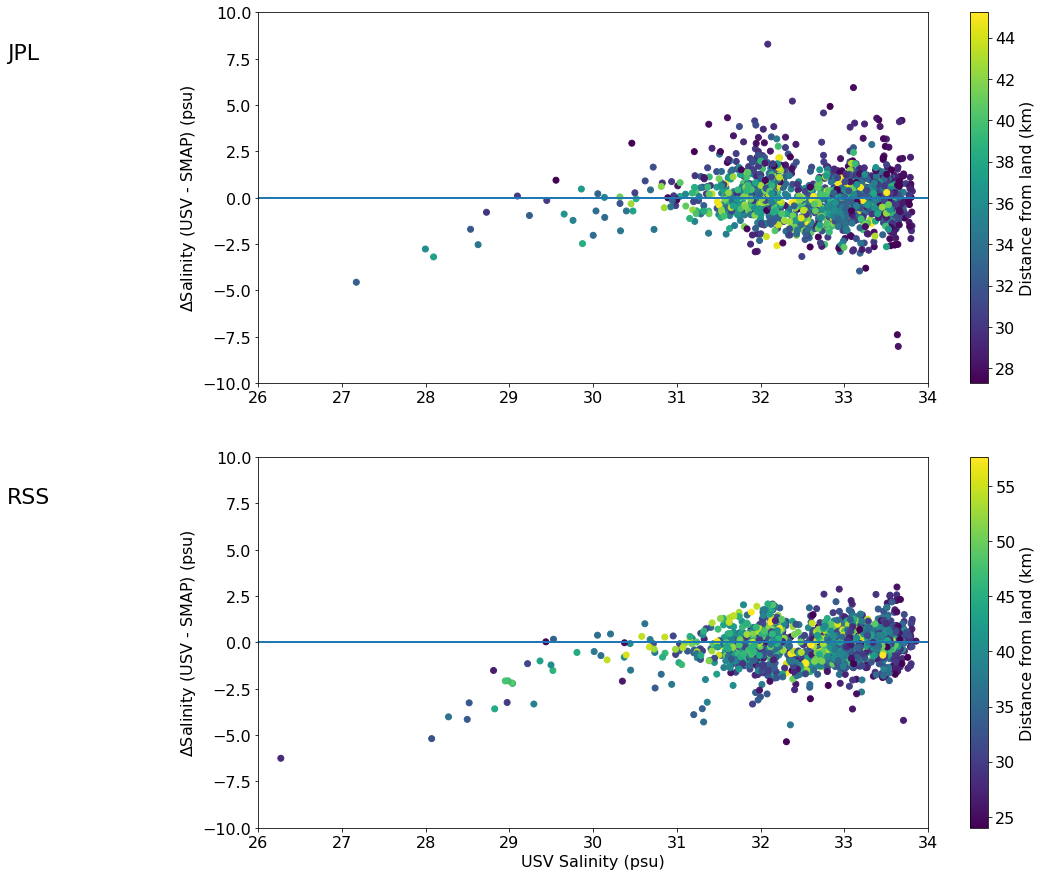

In [241]:
plt.rcParams['figure.figsize'] = (15.0,15.0)
plt.rcParams.update({'font.size': 16})
for i in range(13):
    ds = ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26))
    dif = ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,1)
    plt.scatter(ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS,c=ds.dist_land)
    plt.axhline(0)
plt.text(23,7.5,'JPL',fontsize=22)
plt.xlim(26,34),plt.ylim(-10,10),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)')
cb=plt.colorbar(label='Distance from land (km)')
for i in range(13):
    ds = ds_colR.isel(trajectory=i)
    dif = ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,2)
    plt.axhline(0)
    plt.scatter(ds.SAL_CTD_MEAN,ds.SAL_CTD_MEAN-ds.smap_SSS,c=ds.dist_land)
plt.text(23,7.5,'RSS',fontsize=22)
plt.xlim(26,34),plt.ylim(-10,10),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)'),plt.xlabel('USV Salinity (psu)')
cb=plt.colorbar(label='Distance from land (km)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_scatter.png'
plt.savefig(fig_fname, transparent=False, format='png')

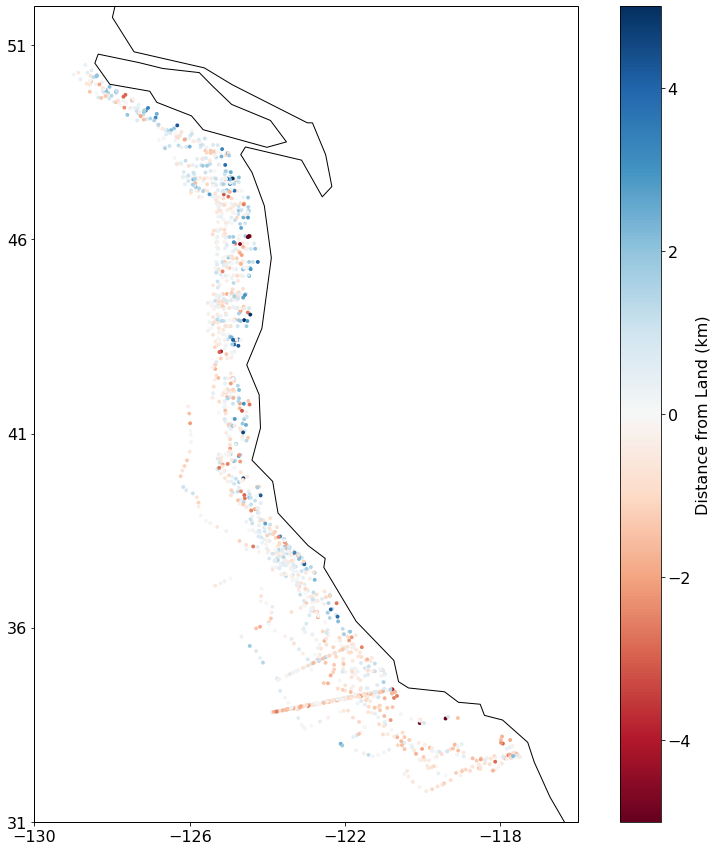

In [217]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ds = ds.where(ds.dist_land>25)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_difJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

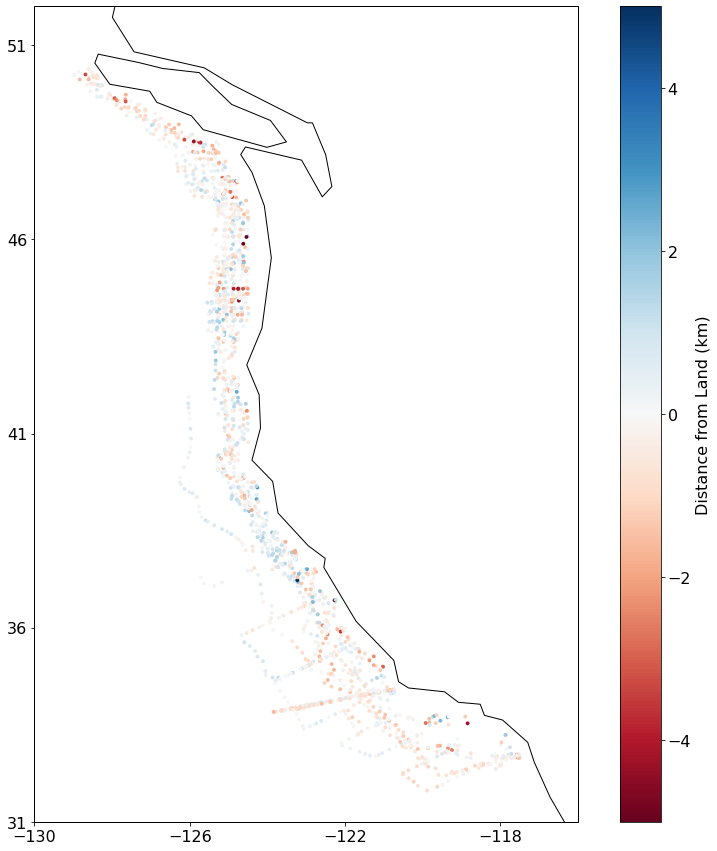

In [215]:
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
#    ds = ds.where(ds.dist_land>30)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_difRSS.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [242]:
ds=ds_colJ.where((ds_colJ.dist_land>26) & (ds_colJ.SAL_CTD_MEAN>26))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print(ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print(ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)

-0.038923009951347155 1.1946489156396571 1590.0
-0.13164188231470447 1.2069123597980889 1730.0


In [180]:
ds1 = xr.open_dataset('F:/data/sat_data/smap/SSS/L2/JPL/V4.3/2019/001/SMAP_L2B_SSS_20921_20190101T005415_R16022_V4.3.h5')
ds2 = xr.open_dataset('F:/data/sat_data/smap/SSS/L2/RSS/V4/SCI/2019/001/RSS_SMAP_SSS_L2C_r20921_20190101T005327_2019001_FNL_V04.0.nc')

In [182]:
ds1

<xarray.Dataset>
Dimensions:               (phony_dim_0: 76, phony_dim_1: 1624, phony_dim_2: 4)
Coordinates:
    lat                   (phony_dim_0, phony_dim_1) float32 ...
    lon                   (phony_dim_0, phony_dim_1) float32 ...
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    anc_dir               (phony_dim_0, phony_dim_1) float32 ...
    anc_spd               (phony_dim_0, phony_dim_1) float32 ...
    anc_sss               (phony_dim_0, phony_dim_1) float32 ...
    anc_sst               (phony_dim_0, phony_dim_1) float32 ...
    anc_swh               (phony_dim_0, phony_dim_1) float32 ...
    antazi_aft            (phony_dim_0, phony_dim_1) float32 ...
    antazi_fore           (phony_dim_0, phony_dim_1) float32 ...
    azi_aft               (phony_dim_0, phony_dim_1) float32 ...
    azi_fore              (phony_dim_0, phony_dim_1) float32 ...
    ice_concentration     (phony_dim_0, phony_dim_1) float32 ...
    inc_aft               (phony_dim_0, phony_dim_1) float32 ...
    inc_fore              (phony_dim_0, phony_dim_1) float32 ...
    land_fraction_aft     (phony_dim_0, phony_dim_1) float32 ...
    land_fraction_fore    (phony_dim_0, phony_dim_1) float32 ...
    n_h_aft               (phony_dim_0, phony_dim_1) float32 ...
    n_h_fore              (phony_dim_0, phony_dim_1) float32 ...
    n_v_aft               (phony_dim_0, phony_dim_1) float32 ...
    n_v_fore              (phony_dim_0, phony_dim_1) float32 ...
    nedt_h_aft            (phony_dim_0, phony_dim_1) float32 ...
    nedt_h_fore           (phony_dim_0, phony_dim_1) float32 ...
    nedt_v_aft            (phony_dim_0, phony_dim_1) float32 ...
    nedt_v_fore           (phony_dim_0, phony_dim_1) float32 ...
    num_ambiguities       (phony_dim_0, phony_dim_1) float32 ...
    quality_flag          (phony_dim_0, phony_dim_1) float32 ...
    row_time              (phony_dim_1) datetime64[ns] ...
    smap_ambiguity_dir    (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    smap_ambiguity_spd    (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    smap_high_dir         (phony_dim_0, phony_dim_1) float32 ...
    smap_high_dir_smooth  (phony_dim_0, phony_dim_1) float32 ...
    smap_high_spd         (phony_dim_0, phony_dim_1) float32 ...
    smap_spd              (phony_dim_0, phony_dim_1) float32 ...
    smap_sss              (phony_dim_0, phony_dim_1) float32 ...
    smap_sss_uncertainty  (phony_dim_0, phony_dim_1) float32 ...
    tb_h_aft              (phony_dim_0, phony_dim_1) float32 ...
    tb_h_bias_adj         (phony_dim_0, phony_dim_1) float32 ...
    tb_h_fore             (phony_dim_0, phony_dim_1) float32 ...
    tb_v_aft              (phony_dim_0, phony_dim_1) float32 ...
    tb_v_bias_adj         (phony_dim_0, phony_dim_1) float32 ...
    tb_v_fore             (phony_dim_0, phony_dim_1) float32 ...
Attributes:
    REVNO:                       20921
    REV_START_YEAR:              2019
    REV_START_DAY_OF_YEAR:       1
    Number of Cross Track Bins:  76
    Number of Along Track Bins:  1624
    REV_START_TIME:              2019-001T00:54:15.000
    REV_STOP_TIME:               2019-001T02:32:42.000
    TB_CRID:                     R16022
    L1B_TB_LORES_ASC_FILE:       /mirror/opsLOM/PRODUCTS/L1B_TB/004/2019/01/0...
    L1B_TB_LORES_DEC_FILE:       /mirror/opsLOM/PRODUCTS/L1B_TB/004/2019/01/0...
    Delta TBH Fore Ascending:    4.530664
    Delta TBH Aft Ascending:     4.530664
    Delta TBV Fore Ascending:    3.095776
    Delta TBV Aft Ascending:     3.095776
    Delta TBH Fore Decending:    4.530664
    Delta TBH Aft Decending:     4.530664
    Delta TBV Fore Decending:    3.095776
    Delta TBV Aft Decending:     3.095776
    QS_ICEMAP_FILE:              /testbed/saline/fore/smap-ancillary/ice/NCEP...
    TB_FLAT_MODEL_FILE:          /home/fore/smap-sds/config/dat/LBandTBFlat-v...
    TB_ROUGH_MODEL_FILE:         /testbed/saline/fore/winds-salinity/tb-winds...
    ANC_U10_FILE:              

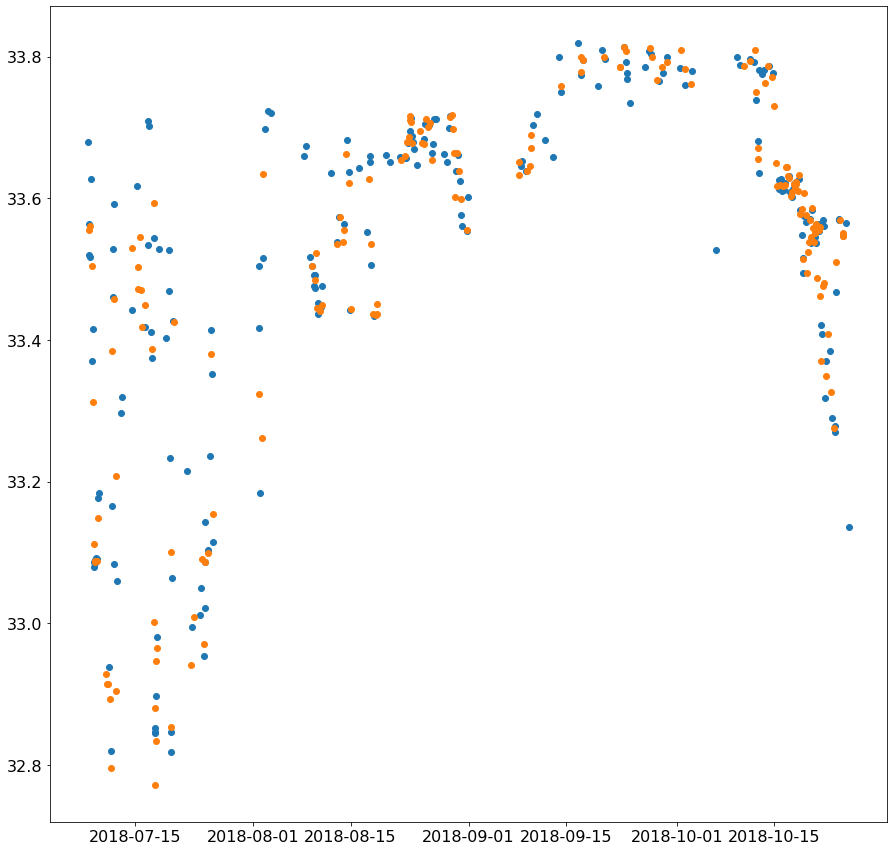

In [259]:
ds1=ds_colJ.isel(trajectory=2)
ds2=ds_colR.isel(trajectory=2)
plt.scatter(ds1.time.data,ds1.SAL_CTD_MEAN)
plt.scatter(ds2.time.data,ds2.SAL_CTD_MEAN)

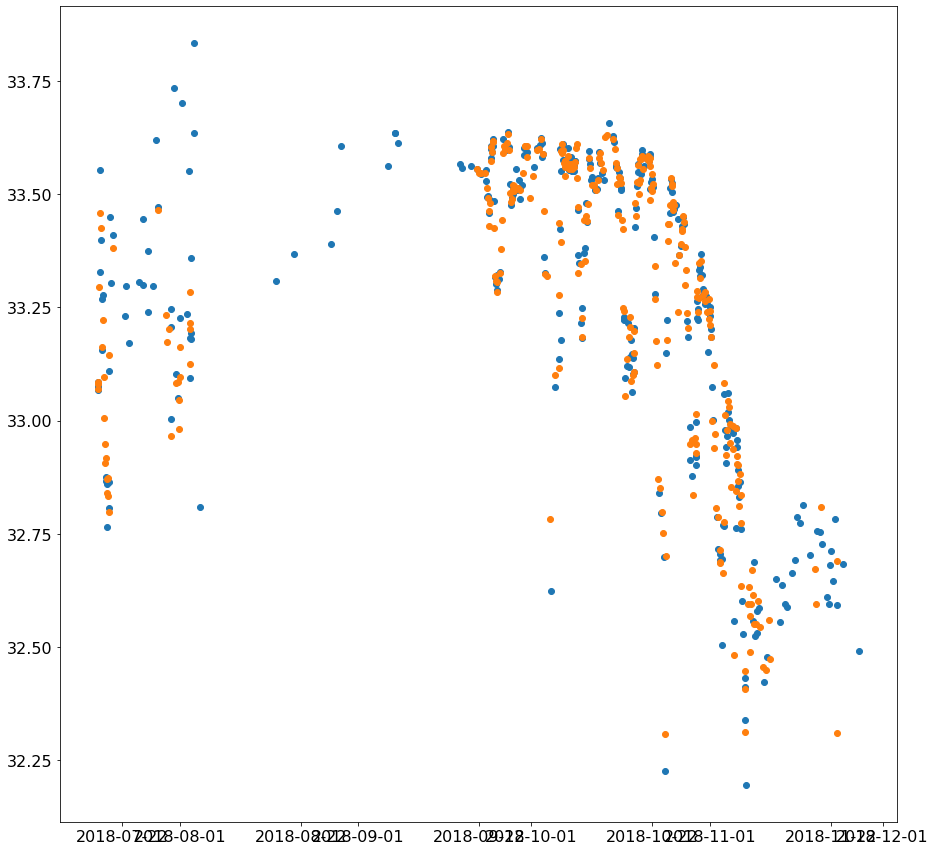